In [ ]:
!pip install datasets
!pip install transformers[torch]
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TrainingArguments, BertForSequenceClassification, Trainer, BertModel
import torch

In [ ]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

<ipython-input-3-581f198a506b>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 84037 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
emotion_corpus = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print (emotion_corpus)
print (emotion_corpus['train'][0])
emotion_corpus_train =  emotion_corpus['train']
emotion_corpus_validation = emotion_corpus['validation']
emotion_corpus_test = emotion_corpus['test']

print(f"{emotion_corpus_validation.column_names}\n{emotion_corpus['validation'].features}")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
                      text  label
0  i didnt feel humiliated      0
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
emotion_corpus_train.set_format(type="pandas")
emotion_corpus_validation.set_format(type="pandas")
emotion_corpus_test.set_format(type="pandas")
df_emotion_corpus_train = emotion_corpus_train[:]
df_emotion_corpus_validation = emotion_corpus_validation[:]
df_emotion_corpus_test = emotion_corpus_test[:]
print (df_emotion_corpus_validation)

                                                   text  label
0     im feeling quite sad and sorry for myself but ...      0
1     i feel like i am still looking at a blank canv...      0
2                        i feel like a faithful servant      2
3                     i am just feeling cranky and blue      3
4     i can have for a treat or if i am feeling festive      1
...                                                 ...    ...
1995  im having ssa examination tomorrow in the morn...      0
1996  i constantly worry about their fight against n...      1
1997  i feel its important to share this info for th...      1
1998  i truly feel that if you are passionate enough...      1
1999  i feel like i just wanna buy any cute make up ...      1

[2000 rows x 2 columns]


In [ ]:
df_emotion_corpus_validation["label_name"] = df_emotion_corpus_validation["label"].apply(lambda x: emotion_corpus_validation.features["label"].int2str(x))
print(df_emotion_corpus_validation[["text", "label_name"]])
print (df_emotion_corpus_validation["label_name"])
print (type(df_emotion_corpus_validation["label_name"]))
label_name = df_emotion_corpus_validation["label_name"].unique()
print (label_name)


                                                   text label_name
0     im feeling quite sad and sorry for myself but ...    sadness
1     i feel like i am still looking at a blank canv...    sadness
2                        i feel like a faithful servant       love
3                     i am just feeling cranky and blue      anger
4     i can have for a treat or if i am feeling festive        joy
...                                                 ...        ...
1995  im having ssa examination tomorrow in the morn...    sadness
1996  i constantly worry about their fight against n...        joy
1997  i feel its important to share this info for th...        joy
1998  i truly feel that if you are passionate enough...        joy
1999  i feel like i just wanna buy any cute make up ...        joy

[2000 rows x 2 columns]
0       sadness
1       sadness
2          love
3         anger
4           joy
         ...   
1995    sadness
1996        joy
1997        joy
1998        joy
1999       

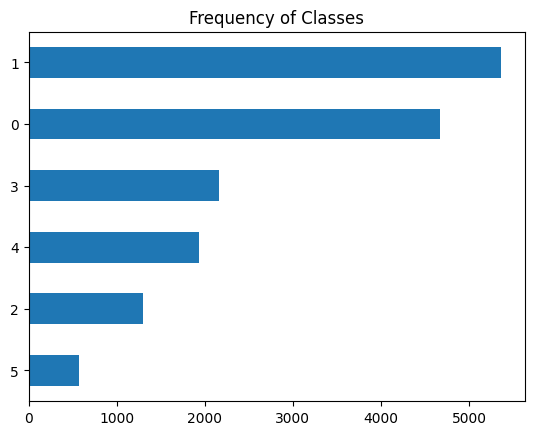

In [ ]:
df_emotion_corpus_train['label'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

In [ ]:
#https://huggingface.co/bert-base-uncased
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Vocabulary size
print (tokenizer.vocab_size)
#Maximum context size
print (tokenizer.model_max_length)


30522
512


In [ ]:
#Subword Tokenization. Combine the best aspects of character and word tokenization.
      #1) split rare words into smaller units to allow the model to deal with complex words and misspellings
      #2)  keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size
text_example = 'Tokenizing text is a core task of NLP.'
encoded_text = tokenizer(text_example)
print (encoded_text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print (tokens)
print(tokenizer.convert_tokens_to_string(tokens))


{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokenizing text is a core task of nlp . [SEP]


In [ ]:
#Training using pretrained model weights
#from transformers import AutoModel
#import torch
model_ckpt = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = AutoModel.from_pretrained(model_ckpt).to(device)
model = BertModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

outputs.last_hidden_state.size()
#The hidden state tensor has the shape [batch_size, n_tokens, hidden_dim]. A 768-dimensional vector is returned for each of the 6 input tokens.

#For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:
outputs.last_hidden_state[:,0].size()


Input tensor shape: torch.Size([1, 6])
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0260,  0.1920,  0.0344,  ..., -0.1346,  0.0773,  0.2477],
         [-0.5674, -0.2561,  0.3124,  ..., -0.7818,  0.2190,  0.5927],
         [-0.2362, -0.3177,  0.6953,  ..., -0.2110,  0.1040,  0.9891],
         [-0.1820, -0.3069,  1.0218,  ..., -0.1590,  0.0841,  1.3962],
         [ 0.0534, -0.4904, -0.0244,  ...,  0.1503,  0.1478, -0.2623],
         [ 0.7536,  0.1498, -0.2997,  ...,  0.0948, -0.8660, -0.2169]]],
       device='cuda:0'), pooler_output=tensor([[-8.1014e-01, -1.6611e-01,  6.8872e-01,  5.6120e-01, -4.2450e-01,
         -1.0617e-01,  8.4508e-01,  1.5211e-01,  4.0698e-01, -9.9904e-01,
          3.3192e-01, -2.4647e-01,  9.5928e-01, -3.5368e-01,  8.7687e-01,
         -4.3937e-01,  1.3539e-02, -4.6144e-01,  2.8961e-01, -7.3881e-01,
          4.2921e-01,  2.6882e-01,  6.9294e-01,  1.8854e-01,  2.5857e-01,
         -3.1407e-01, -3.8146e-01,  8.7916e-01,  9.1173e-01, 

torch.Size([1, 768])

In [ ]:
from tqdm import tqdm
#Batch tokenization

def get_embeddings(sentences, batch_size=40, max_length = 64):
  #disable automatic calculation of the gradient - reduces the memory consumption
  with torch.no_grad():
    for idx in tqdm(range(0, len(list(sentences)), batch_size)):
      batched_sentences = sentences[idx : min(len(sentences), idx + batch_size)]
      # padding=True will pad the examples with zeros to the size of the longest one in a batch
      # padding=max_length will pad the examples with zeros to the size of the longest one in a batch
      #truncation=True will truncate the examples to the model’s maximum context size
      encoded = tokenizer(batched_sentences,  truncation=True, return_tensors='pt', padding='max_length', max_length=max_length).to("cuda")
      #extract embedding of the first [CLS] token
      yield model(**encoded).last_hidden_state[:,0].cpu().numpy()


In [ ]:
batched_train_embeddings = list(get_embeddings(df_emotion_corpus_train["text"].tolist()))
batched_validation_embeddings = list(get_embeddings(df_emotion_corpus_validation["text"].tolist()))
batched_test_embeddings = list(get_embeddings(df_emotion_corpus_test["text"].tolist()))
y_train = df_emotion_corpus_train["label"].tolist()
y_validation = df_emotion_corpus_validation["label"].tolist()
y_test = df_emotion_corpus_test["label"].tolist()

100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


In [ ]:
train_embeddings = [embedding for single_batch_embedding in batched_train_embeddings for embedding in single_batch_embedding]
validation_embeddings = [embedding for single_batch_embedding in batched_train_embeddings for embedding in single_batch_embedding]
test_embeddings = [embedding for single_batch_embedding in batched_test_embeddings for embedding in single_batch_embedding]

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=3000)
clf.fit(train_embeddings, y_train)
clf.score(test_embeddings, y_test)

#from sklearn.svm import SVC
#clf = SVC(gamma=2, C=1).fit(train_embeddings, y_train)
#clf.score(test_embeddings, y_test)

0.6045

[1 0 0 ... 1 1 4]


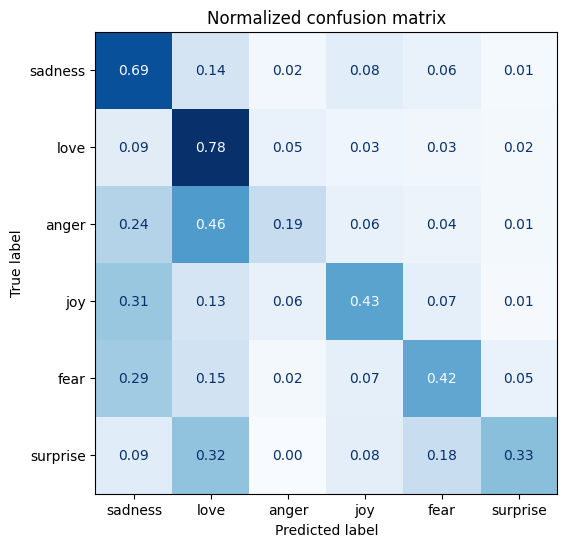

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()

y_preds = clf.predict(test_embeddings)
print (y_preds)
plot_confusion_matrix(y_preds, y_test, label_name)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds, target_names=label_name))

              precision    recall  f1-score   support

     sadness       0.61      0.69      0.65       581
        love       0.69      0.78      0.73       695
       anger       0.30      0.19      0.23       159
         joy       0.54      0.43      0.48       275
        fear       0.52      0.42      0.46       224
    surprise       0.40      0.33      0.36        66

    accuracy                           0.60      2000
   macro avg       0.51      0.47      0.49      2000
weighted avg       0.59      0.60      0.59      2000

